In [1]:
import pandas as pd

In [2]:
responses = pd.read_csv("responses.csv")
responses.head()

,Participant.ID,Timestamp,Center,Left,Right,Answer,Response.Time..s.,Alg.Label,origTime,origAlg.Label
0,1099,2001-01-01 00:00:00.000001,i0464,i0532,i0546,i0532,7955,Train,31:28.0,Random
1,1099,2001-01-01 00:00:00.000002,i0246,i0386,i0462,i0386,2233,Train,31:28.0,Random
2,1099,2001-01-01 00:00:00.000003,i0524,i0586,i0412,i0586,3627,Test,31:28.0,Test
3,1100,2001-01-01 00:00:00.000004,i0444,i0116,i0034,i0116,1775,Train,36:54.0,Uncertainty
4,1100,2001-01-01 00:00:00.000005,i0308,i0236,i0050,i0236,1445,Train,36:54.0,Uncertainty


In [5]:
random = responses["origAlg.Label"] == "Random"
df = responses.loc[random, ["Center", "Left", "Right", "Answer"]].copy()
df.columns = ["head", "left", "right", "winner"]
for c in df.columns:
    df[c] = df[c].apply(lambda x: int(x.replace("i", "")))
    zero_min = df[c] - df[c].min()
    df[c] = zero_min / zero_min.max()
print(df.iloc[0])
df.describe()

head      0.772575
left      0.886288
right     0.909699
winner    0.886288
Name: 0, dtype: float64


,head,left,right,winner
count,7456.000000,7456.000000,7456.000000,7456.000000
mean,0.498529,0.508742,0.492428,0.508742
std,0.289540,0.268817,0.311041,0.268817
min,0.000000,0.000000,0.000000,0.000000
25%,0.250836,0.287625,0.200669,0.287625
50%,0.498328,0.508361,0.498328,0.508361
75%,0.749164,0.725753,0.779264,0.725753
max,1.000000,1.000000,1.000000,1.000000


In [9]:
import numpy as np

def choose_winner(row):
    ldiff = np.abs(row["head"] - row["left"])
    rdiff = np.abs(row["head"] - row["right"])
    if ldiff <= rdiff:
        winner = row["left"]
    else:
        winner = row["right"]
    return winner

df["ground_truth"] = df.apply(choose_winner, axis=1)
ldiff = np.abs(df["head"] - df["left"])
rdiff = np.abs(df["head"] - df["right"])
df["ldiff"] = ldiff
df["rdiff"] = rdiff
df["min_diff"] = np.minimum(ldiff, rdiff)
df["max_diff"] = np.maximum(ldiff, rdiff)
df["ratio"] = df["max_diff"] / (df["max_diff"] + df["min_diff"])
df["correct"] = df["winner"] == df["ground_truth"]
df.head()

,head,left,right,winner,ground_truth,ldiff,rdiff,min_diff,max_diff,ratio,correct,ratio_rounded
0,0.772575,0.886288,0.909699,0.886288,0.886288,0.113712,0.137124,0.113712,0.137124,0.546667,True,0.55
1,0.408027,0.642140,0.769231,0.642140,0.642140,0.234114,0.361204,0.234114,0.361204,0.606742,True,0.61
9,0.591973,0.387960,0.411371,0.387960,0.411371,0.204013,0.180602,0.180602,0.204013,0.530435,False,0.53
12,0.488294,0.585284,0.371237,0.585284,0.585284,0.096990,0.117057,0.096990,0.117057,0.546875,True,0.55
13,0.063545,0.107023,0.742475,0.107023,0.107023,0.043478,0.678930,0.043478,0.678930,0.939815,True,0.94


In [10]:
import seaborn as sns

df["ratio_rounded"] = np.round(df["ratio"], decimals=2)
np.unique(np.sort(df["ratio_rounded"]))[-10:]

array([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

tanh [9.3130595  0.45659234]
sigmoid [19.5270248]


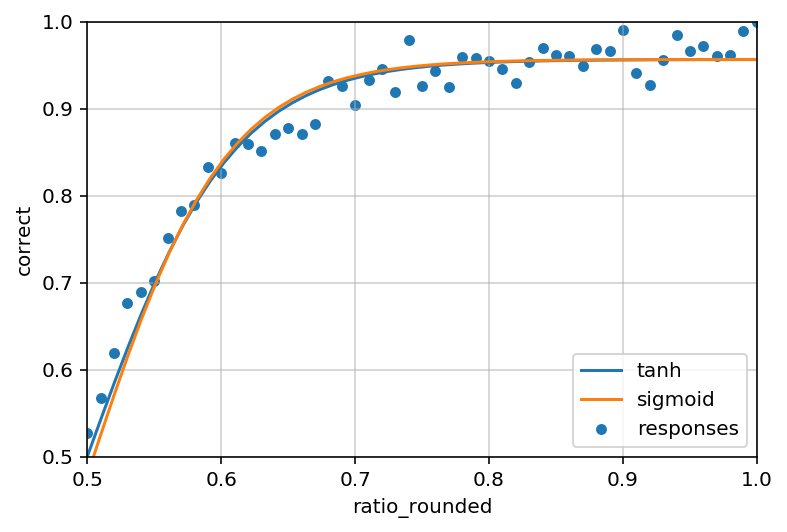

In [11]:
from scipy.optimize import curve_fit

def tanh(x, rate=7.4, final=0.47):
    return final * np.tanh(rate * (x - 0.5)) + 0.5

def sigmoid(x, rate):
    return 0.9567 / (1 + np.exp(-rate * (x - 0.5)))

show = df.pivot_table(
    index="ratio_rounded",
    values="correct",
    aggfunc="mean",
).reset_index()
    

x = show["ratio_rounded"].values
y = show["correct"].values

ax = show.plot.scatter(x="ratio_rounded", y="correct", label="responses")
ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)

for fn in [tanh, sigmoid]:
    popt, pcov = curve_fit(fn, x, y)
    x_show = np.linspace(0.5, 1)
    y_show = fn(x_show, *popt)
    ax.plot(x_show, y_show, label=fn.__name__)
    print(fn.__name__, popt)
ax.legend(loc="best")
ax.grid(alpha=0.6)

So then

$$\mathbb{P}(\text{correct}) = \frac{0.9567}{1 + \exp\left[-19.52697 (r - 0.5) \right]}$$

where $$r = \frac{s_{\max}}{s_{\min} + s_{\max}}$$

In [22]:
df["correct"]

0         True
1         True
9        False
12        True
13        True
         ...  
17600     True
17602     True
17603     True
17604     True
17610    False
Name: correct, Length: 7456, dtype: bool

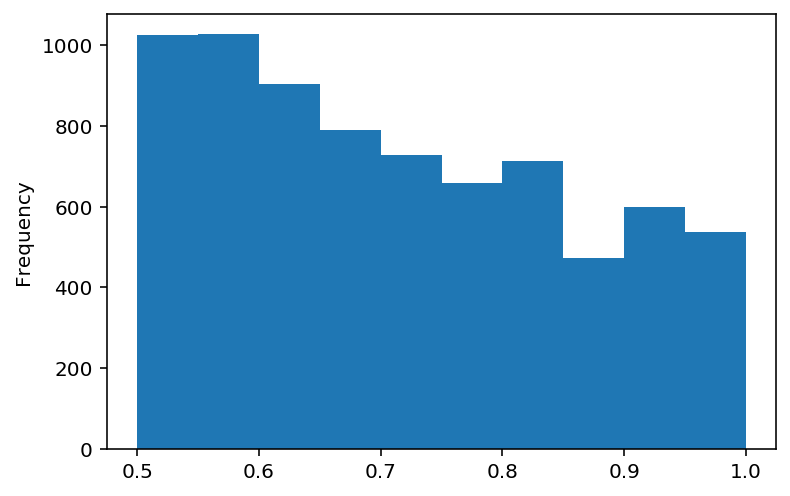

In [23]:
df["ratio_rounded"].plot.hist()

In [12]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.utils import check_random_state


def strange_fruit(head, left, right, random_state=None):
    """
    Parameters
    ----------
    head, left, right : int, int, int
        Number of spikes on the various objects

    Returns
    -------
    winner : str
        Either "left" or "right"

    Notes
    -----
    This is determined from human data.
    See datasets/strange-fruit-triplet/noise-model.ipynb for details.
    """
    ldiff = np.abs(head - left)
    rdiff = np.abs(head - right)

    r = np.maximum(ldiff, rdiff) / (ldiff + rdiff)
    rate = 19.5269746
    final = 0.9567
    p_correct = final / (1 + np.exp(-rate * (r - 0.5)))

    winner = 0 if ldiff < rdiff else 1
    random_state = check_random_state(random_state)
    if random_state.uniform() <= p_correct:
        return winner
    return 1 - winner


In [16]:
strange_fruit(0, 1, 3)

0

In [51]:
rng = np.random.RandomState(42)

n_targets = 600
num_ans = 100_000
X = rng.choice(n_targets, size=(num_ans, 3))
y = [strange_fruit(h, l, r, random_state=rng) for h, l, r in X]

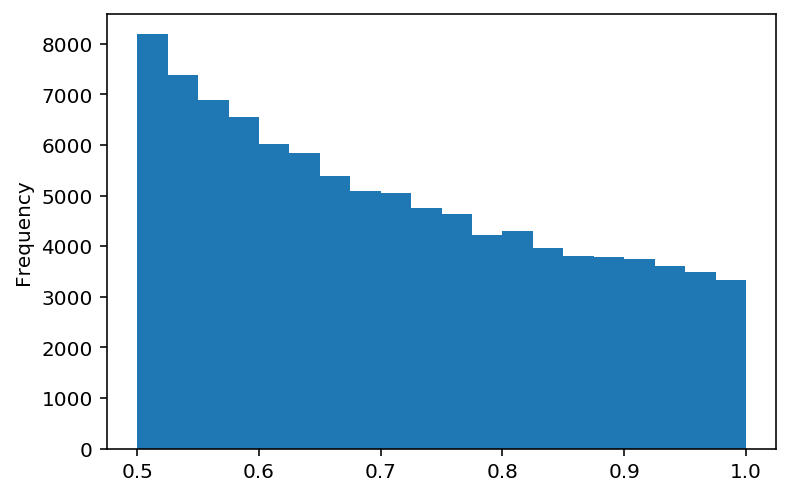

In [52]:
ground_truth = [choose_winner({"head": h, "left": l, "right": r}) for h, l, r in X]

ldiff = np.abs(X[:, 0] - X[:, 1])
rdiff = np.abs(X[:, 0] - X[:, 2])
min_diff = np.minimum(ldiff, rdiff)
max_diff = np.maximum(ldiff, rdiff)
ratio = max_diff / (max_diff + min_diff)
pd.Series(ratio).plot.hist(bins=20)

In [ ]:
n = 100
head = np.arange(n)
l